In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from reconstruct_coordinates import reconstruct_coords_batch
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")


Using device: cpu


In [2]:
data = scipy.io.loadmat('qm7b.mat')

# Extract available data
X = data['X']  # Coulomb matrices: (7211, 23, 23)
T = data['T']  # Properties: (7211, 14)
names = data['names']  # Property names: (14,)

X = np.array(X)
T = np.array(T)

# Get property names
if names.ndim > 1:
    property_names = [str(names[i][0]) for i in range(len(names))]
else:
    property_names = [str(names[i]) for i in range(len(names))]

print(f"Dataset shapes:")
print(f"  X (Coulomb matrices): {X.shape}")
print(f"  T (Properties): {T.shape}")

# Extract atomic numbers from Coulomb matrix diagonals
# C_ii = 0.5 * Z_i^2.4, so Z_i = (2 * C_ii)^(1/2.4)
Z_list = []
for i in range(len(X)):
    coulomb_diag = np.diag(X[i])
    # Find non-zero diagonal elements (actual atoms)
    atom_indices = np.where(coulomb_diag > 1e-6)[0]
    if len(atom_indices) > 0:
        z_vals = (2 * coulomb_diag[atom_indices]) ** (1.0 / 2.4)
        z_vals = np.round(z_vals).astype(int)
        Z_list.append(z_vals)
    else:
        Z_list.append(np.array([1]))


print("Reconstructing coordinate arrays from Coulomb matrices...")
R_list = reconstruct_coords_batch(X, Z_list, method='mds', verbose=True)

Z = np.array(Z_list, dtype=object)
R = np.array(R_list, dtype=object)

print(f"Extracted Z for {len(Z)} molecules")


Dataset shapes:
  X (Coulomb matrices): (7211, 23, 23)
  T (Properties): (7211, 14)
Reconstructing coordinate arrays from Coulomb matrices...
Processing molecule 100/7211...
Processing molecule 200/7211...
Processing molecule 300/7211...
Processing molecule 400/7211...
Processing molecule 500/7211...
Processing molecule 600/7211...
Processing molecule 700/7211...
Processing molecule 800/7211...
Processing molecule 900/7211...
Processing molecule 1000/7211...
Processing molecule 1100/7211...
Processing molecule 1200/7211...
Processing molecule 1300/7211...
Processing molecule 1400/7211...
Processing molecule 1500/7211...
Processing molecule 1600/7211...
Processing molecule 1700/7211...
Processing molecule 1800/7211...
Processing molecule 1900/7211...
Processing molecule 2000/7211...
Processing molecule 2100/7211...
Processing molecule 2200/7211...
Processing molecule 2300/7211...
Processing molecule 2400/7211...
Processing molecule 2500/7211...
Processing molecule 2600/7211...
Processin

In [3]:
def compute_spherical_harmonics(r, max_l=2):
    batch_size, n_atoms, _ = r.shape
    device = r.device
    
    # Convert into spherical coordinates
    x, y, z = r[..., 0], r[..., 1], r[..., 2]
    r_norm = torch.norm(r, dim=-1, keepdim=True) 

    r_norm = r_norm + 1e-8 # avoid division by zero
    cos_theta = z / r_norm.squeeze(-1)
    theta = torch.acos(torch.clamp(cos_theta, -1.0, 1.0))
    phi = torch.atan2(y, x)
    
    harmonics = []
    
    for l in range(max_l + 1):
        for m in range(-l, l + 1):
            if l == 0:
                # Y_0^0 = 1/sqrt(4*pi) - constant term (s orbital)
                y_lm = torch.ones(batch_size, n_atoms, device=device) / np.sqrt(4 * np.pi)
            elif l == 1:
                if m == -1:
                    # Y_1^{-1}
                    y_lm = np.sqrt(3 / (4 * np.pi)) * torch.sin(theta) * torch.cos(phi)
                elif m == 0:
                    # Y_1^0
                    y_lm = np.sqrt(3 / (4 * np.pi)) * cos_theta
                elif m == 1:
                    # Y_1^1
                    y_lm = -np.sqrt(3 / (4 * np.pi)) * torch.sin(theta) * torch.sin(phi)
            elif l == 2:
                if m == -2:
                    # Y_2^{-2}
                    y_lm = np.sqrt(15 / (4 * np.pi)) * torch.sin(theta) ** 2 * torch.sin(2 * phi) / 2
                elif m == -1:
                    # Y_2^{-1}
                    y_lm = np.sqrt(15 / (4 * np.pi)) * torch.sin(theta) * cos_theta * torch.sin(phi)
                elif m == 0:
                    # Y_2^0
                    y_lm = np.sqrt(5 / (4 * np.pi)) * (3 * cos_theta ** 2 - 1) / 2
                elif m == 1:
                    # Y_2^1
                    y_lm = -np.sqrt(15 / (4 * np.pi)) * torch.sin(theta) * cos_theta * torch.cos(phi)
                elif m == 2:
                    # Y_2^2
                    y_lm = np.sqrt(15 / (4 * np.pi)) * torch.sin(theta) ** 2 * torch.cos(2 * phi) / 2
            else:
                y_lm = torch.zeros(batch_size, n_atoms, device=device)
            
            harmonics.append(y_lm)
    
    harmonics_tensor = torch.stack(harmonics, dim=-1)
    return harmonics_tensor


def compute_radial_basis(r, n_radial=8, cutoff=5.0):
    r_norm = torch.norm(r, dim=-1, keepdim=True)  # (batch, n_atoms, 1)
    
    centers = torch.linspace(0.0, cutoff, n_radial, device=r.device)
    widths = cutoff / n_radial
    
    r_expanded = r_norm.squeeze(-1).unsqueeze(-1)
    centers_expanded = centers.unsqueeze(0).unsqueeze(0)
    
    radial_basis = torch.exp(-((r_expanded - centers_expanded) / widths) ** 2)
    
    return radial_basis


class SphericalConv(nn.Module):
    def __init__(self, n_in, n_out, max_l=2, n_radial=8, cutoff=5.0):
        super(SphericalConv, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.max_l = max_l
        self.n_radial = n_radial
        self.cutoff = cutoff
        
        # num of spherical harmonics: (max_l+1)^2, e.g. max_l=2, 9 harmonics
        self.n_harmonics = (max_l + 1) ** 2
        
        # spherical feature dimension: n_harmonics * n_radial
        self.spherical_dim = self.n_harmonics * n_radial
        
        # project to spherical space
        self.to_spherical = nn.Linear(n_in, self.spherical_dim)
        self.spherical_conv = nn.Linear(self.spherical_dim, self.spherical_dim)
        self.from_spherical = nn.Linear(self.spherical_dim, n_out)
        self.norm = nn.LayerNorm(n_out)
        
    def forward(self, x, positions, mask):
        batch_size, n_atoms, _ = x.shape
        
        harmonics = compute_spherical_harmonics(positions, max_l=self.max_l)
        radial = compute_radial_basis(positions, n_radial=self.n_radial, cutoff=self.cutoff)
        
        harmonics_expanded = harmonics.unsqueeze(-1)
        radial_expanded = radial.unsqueeze(-2)
        spherical_features = (harmonics_expanded * radial_expanded).view(batch_size, n_atoms, -1)
        
        x_spherical = self.to_spherical(x)
        x_spherical = x_spherical * spherical_features
        x_spherical = self.spherical_conv(x_spherical)
        x_spherical = F.relu(x_spherical)
        
        out = self.from_spherical(x_spherical)
        out = self.norm(out)
        out = out * mask.unsqueeze(-1)
        
        return out


class SphericalMessagePassing(nn.Module):
    def __init__(self, n_in, n_out, max_l=2, n_radial=8, cutoff=5.0, eps=0.0, train_eps=True):
        super(SphericalMessagePassing, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.initial_eps = eps
        
        if train_eps:
            self.eps = nn.Parameter(torch.tensor([eps]))
        else:
            self.register_buffer('eps', torch.tensor([eps]))
        
        self.spherical_conv = SphericalConv(n_in, n_out, max_l, n_radial, cutoff)
        
        self.mlp = nn.Sequential(
            nn.Linear(n_out, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
            nn.Linear(n_out, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU()
        )
        
    def forward(self, x, positions, edge_index, mask):
        batch_size = positions.shape[0]
        n_atoms = positions.shape[1]
        
        x_reshaped = x.view(batch_size, n_atoms, -1)
        mask_reshaped = mask.view(batch_size, n_atoms)
        x_spherical = self.spherical_conv(x_reshaped, positions, mask_reshaped)
        x_flat = x_spherical.view(-1, self.n_out)
        row, col = edge_index
        neighbor_features = x_flat[col]
        
        out = torch.zeros_like(x_flat)
        if len(row) > 0:
            out.index_add_(0, row, neighbor_features)
        
        out = (1 + self.eps) * x_flat + out
        out = out * mask.unsqueeze(-1)
        
        out_flat = out.view(-1, self.n_out)
        out_mlp = self.mlp(out_flat)
        out = out_mlp.view(batch_size * n_atoms, -1)
        out = out * mask.unsqueeze(-1)
        
        return out


class GSCNNLayer(nn.Module):
    def __init__(self, n_in, n_out, max_l=2, n_radial=8, cutoff=5.0, eps=0.0, train_eps=True):
        super(GSCNNLayer, self).__init__()
        self.spherical_mp = SphericalMessagePassing(n_in, n_out, max_l, n_radial, cutoff, eps, train_eps)
        self.norm = nn.LayerNorm(n_out)
        
        if n_in != n_out:
            self.residual_proj = nn.Linear(n_in, n_out)
        else:
            self.residual_proj = None
        
    def forward(self, x, positions, edge_index, mask):
        residual = x
        if self.residual_proj is not None:
            residual = self.residual_proj(residual)
        
        out = self.spherical_mp(x, positions, edge_index, mask)
        out = self.norm(out)
        out = out + residual
        out = out * mask.unsqueeze(-1)
        
        return out


class GSCNN(nn.Module):
    def __init__(self, n_atom_basis=128, n_layers=3, 
                 n_out=14, max_atoms=23, dropout=0.1,
                 max_l=2, n_radial=8, cutoff=5.0):
        super(GSCNN, self).__init__()
        self.n_atom_basis = n_atom_basis
        self.n_layers = n_layers
        self.max_atoms = max_atoms
        self.dropout = dropout
        self.max_l = max_l
        self.n_radial = n_radial
        self.cutoff = cutoff
        
        self.embedding = nn.Embedding(100, n_atom_basis)
        self.gscnn_layers = nn.ModuleList()
        for i in range(n_layers):
            self.gscnn_layers.append(
                GSCNNLayer(n_atom_basis, n_atom_basis, max_l, n_radial, cutoff, eps=0.0, train_eps=True)
            )
        
        self.atom_wise = nn.Sequential(
            nn.Linear(n_atom_basis, n_atom_basis),
            nn.BatchNorm1d(n_atom_basis),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(n_atom_basis, n_atom_basis),
            nn.BatchNorm1d(n_atom_basis),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(n_atom_basis, n_atom_basis)
        )
        
        self.property_head = nn.Sequential(
            nn.Linear(n_atom_basis, n_atom_basis // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(n_atom_basis // 2, n_out)
        )
        
    def build_edge_index(self, positions, mask, cutoff=5.0):
        batch_size, n_atoms, _ = positions.shape
        device = positions.device
        
        pos_i = positions.unsqueeze(2)  # (batch, n_atoms, 1, 3)
        pos_j = positions.unsqueeze(1)  # (batch, 1, n_atoms, 3)
        diff = pos_i - pos_j  # (batch, n_atoms, n_atoms, 3)
        distances = torch.norm(diff, dim=-1)  # (batch, n_atoms, n_atoms)
        
        mask_i = mask.unsqueeze(2)  # (batch, n_atoms, 1)
        mask_j = mask.unsqueeze(1)  # (batch, 1, n_atoms)
        neighbor_mask = (mask_i * mask_j).float()  # (batch, n_atoms, n_atoms)
        
        eye = torch.eye(n_atoms, device=device).unsqueeze(0)
        neighbor_mask = neighbor_mask * (1 - eye)
        edge_mask = (distances < cutoff) * neighbor_mask
        
        edge_indices = []
        for b in range(batch_size):
            edges = torch.nonzero(edge_mask[b], as_tuple=False)
            if len(edges) > 0:
                edges_offset = edges + b * n_atoms
                edge_indices.append(edges_offset.t())
            else:
                self_loop = torch.arange(n_atoms, device=device) + b * n_atoms
                edge_indices.append(torch.stack([self_loop, self_loop]))
        
        if len(edge_indices) > 0:
            edge_index = torch.cat(edge_indices, dim=1)
        else:
            edge_index = torch.stack([
                torch.arange(batch_size * n_atoms, device=device),
                torch.arange(batch_size * n_atoms, device=device)
            ])
        
        return edge_index
    
    def forward(self, atomic_numbers, positions, mask):
        batch_size, n_atoms, _ = positions.shape
        
        x = self.embedding(atomic_numbers)
        edge_index = self.build_edge_index(positions, mask, cutoff=self.cutoff)
        
        x_flat = x.view(-1, self.n_atom_basis)
        mask_flat = mask.view(-1)
        
        for gscnn_layer in self.gscnn_layers:
            x_flat = gscnn_layer(x_flat, positions, edge_index, mask_flat)
        
        x = x_flat.view(batch_size, n_atoms, self.n_atom_basis)
        
        x_flat = x.view(-1, self.n_atom_basis)
        x_flat = self.atom_wise(x_flat)
        x = x_flat.view(batch_size, n_atoms, self.n_atom_basis)
        
        mask_expanded = mask.unsqueeze(-1).float()
        x_masked = x * mask_expanded
        x_sum = x_masked.sum(dim=1)
        n_atoms = mask.sum(dim=1, keepdim=True).float()
        x_mean = x_sum / (n_atoms + 1e-8)
        
        properties = self.property_head(x_mean)
        
        return properties


In [4]:
class QM7bDataset(Dataset):
    def __init__(self, Z, R, T, max_atoms=23):
        self.Z = Z 
        self.R = R 
        self.T = T 
        self.n_molecules = len(Z) 
        self.max_atoms = max_atoms 
        self.n_properties = T.shape[1] if T.ndim > 1 else 1
        
    def __len__(self):
        return self.n_molecules
    
    def __getitem__(self, idx):
        z = torch.from_numpy(self.Z[idx]).long() 
        r = torch.from_numpy(self.R[idx]).float() 
        t = torch.from_numpy(self.T[idx]).float() if self.T.ndim > 1 else torch.tensor([self.T[idx]]).float() 
        
        mask = (z > 0).float()
        
        return z, r, mask, t


In [5]:
def prepare_molecular_data(Z, R, max_atoms=23):
    n_molecules = len(Z)
    
    Z_processed = []
    R_processed = []
    
    for i in range(n_molecules):
        z_vals = Z[i] if isinstance(Z[i], np.ndarray) else np.array([Z[i]])
        z_vals = z_vals.flatten()
        
        r_vals = R[i] if isinstance(R[i], np.ndarray) else np.zeros((len(z_vals), 3))
        if r_vals.ndim == 1:
            if len(r_vals) >= len(z_vals) * 3:
                r_vals = r_vals[:len(z_vals)*3].reshape(-1, 3)
            else:
                r_vals = np.zeros((len(z_vals), 3))
        elif r_vals.ndim == 2 and r_vals.shape[1] != 3:
            r_vals = np.zeros((len(z_vals), 3))
        
        if r_vals.shape[0] < len(z_vals):
            r_padded_temp = np.zeros((len(z_vals), 3))
            r_padded_temp[:r_vals.shape[0]] = r_vals
            r_vals = r_padded_temp
        elif r_vals.shape[0] > len(z_vals):
            r_vals = r_vals[:len(z_vals)]
        
        n_atoms = min(len(z_vals), max_atoms)
        z_padded = np.zeros(max_atoms, dtype=np.int64)
        r_padded = np.zeros((max_atoms, 3), dtype=np.float32)
        
        z_padded[:n_atoms] = z_vals[:n_atoms]
        r_padded[:n_atoms] = r_vals[:n_atoms]
        
        Z_processed.append(z_padded)
        R_processed.append(r_padded)
    
    return np.array(Z_processed), np.array(R_processed)

Z_processed, R_processed = prepare_molecular_data(Z, R, max_atoms=23)


In [6]:
# Split data to 80% train, 10% validation, 10% test
train_idx, temp_idx = train_test_split(
    np.arange(len(T)), test_size=0.2, random_state=42
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, random_state=42
)

# Create datasets
train_dataset = QM7bDataset(
    Z_processed[train_idx], 
    R_processed[train_idx], 
    T[train_idx],
    max_atoms=23
)
val_dataset = QM7bDataset(
    Z_processed[val_idx], 
    R_processed[val_idx], 
    T[val_idx],
    max_atoms=23
)
test_dataset = QM7bDataset(
    Z_processed[test_idx], 
    R_processed[test_idx], 
    T[test_idx],
    max_atoms=23
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Train samples: 5768
Validation samples: 721
Test samples: 722


In [7]:
model = GSCNN(
    n_atom_basis=128,
    n_layers=3,
    n_out=T.shape[1],
    max_atoms=23,
    dropout=0.1,
    max_l=2,
    n_radial=8,
    cutoff=5.0
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Model parameters: 245,825


In [8]:
def train_epoch(model, loader, criterion, optimizer, device, epoch=None, total_epochs=None):
    model.train()
    total_loss = 0.0
    total_mae = 0.0
    n_batches = 0
    
    for batch_idx, (z, r, mask, t) in enumerate(loader):
        z = z.to(device)
        r = r.to(device)
        mask = mask.to(device)
        t = t.to(device)
        
        optimizer.zero_grad()
        predictions = model(z, r, mask)
        loss = criterion(predictions, t)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        mae = torch.mean(torch.abs(predictions - t)).item()
        
        total_loss += loss.item()
        total_mae += mae
        n_batches += 1
    
    if epoch is not None:
        print()
    
    return total_loss / n_batches, total_mae / n_batches


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    n_batches = 0
    
    with torch.no_grad():
        for z, r, mask, t in loader:
            z = z.to(device)
            r = r.to(device)
            mask = mask.to(device)
            t = t.to(device)
            
            predictions = model(z, r, mask)
            loss = criterion(predictions, t)
            
            mae = torch.mean(torch.abs(predictions - t)).item()
            
            total_loss += loss.item()
            total_mae += mae
            n_batches += 1
    
    return total_loss / n_batches, total_mae / n_batches


n_epochs = 100
train_losses = []
train_maes = []
val_losses = []
val_maes = []
best_val_loss = float('inf')
best_val_mae = float('inf')
patience_counter = 0
max_patience = 20
current_lr = optimizer.param_groups[0]['lr']

print("Starting Training - GSCNN")

for epoch in range(n_epochs):
    # Training phase
    print(f"Epoch [{epoch+1}/{n_epochs}]")
    print(f"  Training...", end=' ')
    train_loss, train_mae = train_epoch(model, train_loader, criterion, optimizer, device, epoch+1, n_epochs)
    train_losses.append(train_loss)
    train_maes.append(train_mae)
    
    # Validation phase
    print(f"  Validating...", end=' ')
    val_loss, val_mae = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_maes.append(val_mae)
    
    # Update learning rate
    old_lr = current_lr
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    lr_reduced = old_lr != current_lr
    
    # Early stopping check (using MSE loss)
    improved = val_loss < best_val_loss
    if improved:
        best_val_loss = val_loss
        best_val_mae = val_mae
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_gscnn_model.pth')
        save_status = "Saved"
    else:
        patience_counter += 1
        save_status = ""
    
    print(f"  Results:")
    print(f"    Train MSE:  {train_loss:.6f}  |  Train MAE:  {train_mae:.6f}")
    print(f"    Val MSE:    {val_loss:.6f}  |  Val MAE:    {val_mae:.6f}")
    print(f"    LR:          {current_lr:.6f}")
    print()
    
    # Early stopping
    if patience_counter >= max_patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

print("Training completed!")
print(f"Total epochs trained: {len(train_losses)}")
print(f"Best validation MSE: {best_val_loss:.6f}")
print(f"Best validation MAE: {best_val_mae:.6f}")


Starting Training - GSCNN
Epoch [1/100]
  Training... 
  Validating...   Results:
    Train MSE:  106492.748076  |  Train MAE:  85.409835
    Val MSE:    1671.746704  |  Val MAE:    10.990288
    LR:          0.001000

Epoch [2/100]
  Training... 
  Validating...   Results:
    Train MSE:  2063.258740  |  Train MAE:  13.797783
    Val MSE:    814.611977  |  Val MAE:    7.097909
    LR:          0.001000

Epoch [3/100]
  Training... 
  Validating...   Results:
    Train MSE:  1667.997099  |  Train MAE:  9.998275
    Val MSE:    479.932928  |  Val MAE:    5.793611
    LR:          0.001000

Epoch [4/100]
  Training... 
  Validating...   Results:
    Train MSE:  1626.767938  |  Train MAE:  9.838125
    Val MSE:    428.684047  |  Val MAE:    5.237374
    LR:          0.001000

Epoch [5/100]
  Training... 
  Validating...   Results:
    Train MSE:  1480.151961  |  Train MAE:  9.861202
    Val MSE:    416.720241  |  Val MAE:    6.119227
    LR:          0.001000

Epoch [6/100]
  Training... 

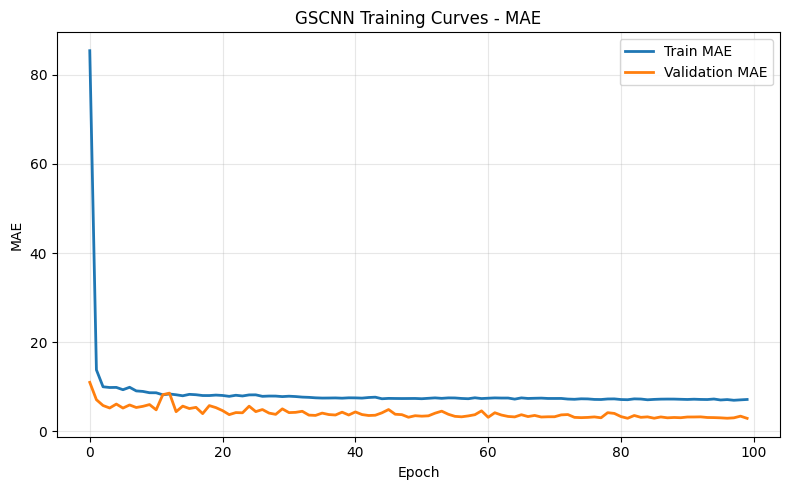

In [9]:
# Plot training curves
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# MAE curves
ax.plot(train_maes, label='Train MAE', linewidth=2)
ax.plot(val_maes, label='Validation MAE', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('MAE')
ax.set_title('GSCNN Training Curves - MAE')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
print("Evaluating the model on the test set")

model.load_state_dict(torch.load('best_gscnn_model.pth'))
model.eval()
test_loss, test_mae = validate(model, test_loader, criterion, device)

print(f"Test MSE:  {test_loss:.6f}")
print(f"Test MAE:  {test_mae:.6f}")


Evaluating the model on the test set
Test MSE:  90.831713
Test MAE:  2.873033
